# Train decoder

## Dataset loading

### Import libraries

In [1]:
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import os

os.chdir("/home/ubuntu/")

/home/ubuntu/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataset

Load the dataset with hugging face and split between train and test.

In [2]:
ds = load_dataset('json', data_files='/home/ubuntu/data/intestinal_organoid_dataset/one_mask_metadata.json')

test_dataset = ds["train"].filter(lambda example: example["split"] == "test")
del(ds)

Define the local folder where the dataset is located.

In [3]:
# Define dataset location folder
data_folder = "/home/ubuntu/data/intestinal_organoid_dataset/"

Define the processor (encoder) of SAM.

In [4]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

Adapt the actual dataset for SAM.

In [5]:
from utils.sam_dataset import SAMDataset
sam_test_dataset = SAMDataset(dataset=test_dataset, processor=processor, data_folder=data_folder)
del(test_dataset)

In [6]:
item = sam_test_dataset[0]
print("Keys in item:", item.keys())  # Add this line to print the keys

Keys in item: dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask', 'original_image'])


### Create PyTorch dataloader

In [7]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(sam_test_dataset, batch_size=1, shuffle=True)

In [8]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  print(k,v.shape)
del(k, v)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])
ground_truth_mask torch.Size([1, 450, 450])
original_image torch.Size([1, 450, 450, 3])


/home/ubuntu/venv/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


# SOLVE PROBLEM OF BATCHES THAT COMBINE IMAGES OF DIFFERENT SIZES. CREATE ONE DATASET FOR SIZE OF IMAGE?

## Train SAM

### Load the model

Make sure we only compute gradients for the mask decoder

In [9]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
del(name)

See first mask prediction.

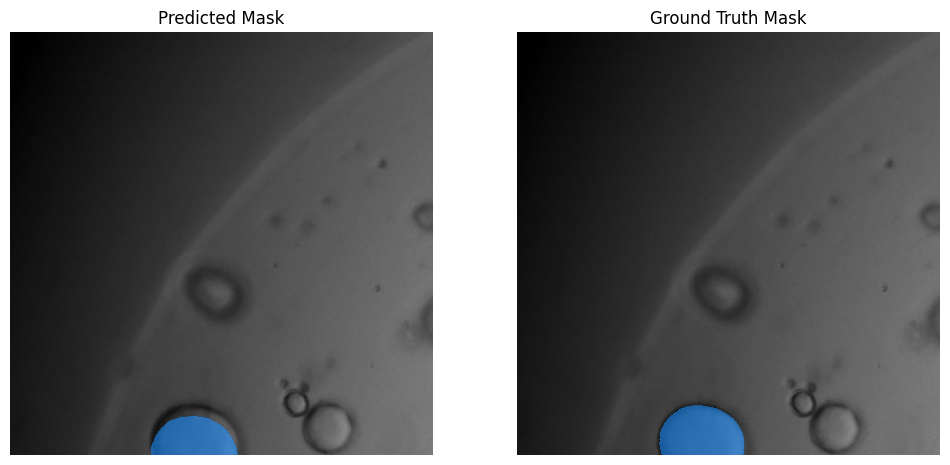

In [10]:
from utils.inference_sam import show_mask

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Compute mask
outputs = model(pixel_values=batch["pixel_values"].to(device),
                input_boxes=batch["input_boxes"].to(device),
                multimask_output=False)
# Post-process mask
predicted_masks = outputs.pred_masks.to(device)
predicted_masks = F.interpolate(predicted_masks.squeeze(1), (1024, 1024), 
                                mode="bilinear", align_corners=False)
predicted_masks = predicted_masks[..., :992, :1024]
predicted_masks = F.interpolate(predicted_masks, (450, 450), 
                                mode="bilinear", align_corners=False)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Predicted Mask
axes[0].imshow(np.array(batch["original_image"]).squeeze())
# apply sigmoid
mask_seg_prob = torch.sigmoid(predicted_masks)
# convert soft mask to hard mask
mask_seg_prob = mask_seg_prob.cpu().squeeze().detach().numpy()
first_mask_seg = (mask_seg_prob > 0.5).astype(np.uint8)
show_mask(first_mask_seg, axes[0])
axes[0].set_title("Predicted Mask")
axes[0].axis("off")

# Plot Ground Truth Mask
ground_truth_masks = batch["ground_truth_mask"].float().squeeze().cpu()
axes[1].imshow(np.array(batch["original_image"]).squeeze())
show_mask(ground_truth_masks, axes[1])
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

plt.show()

### Train the model

In [11]:
from torch.optim import Adam
import monai
from utils.model_training import train_model


# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
# Define loss
geom_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
# Define number of epochs
num_epochs = 100
train_model(model = model, optimizer = optimizer, seg_loss = geom_loss, 
            dataloader = test_dataloader, num_epochs = num_epochs, device = device)

100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


EPOCH: 1
Mean loss: 0.19118240475654602


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


EPOCH: 2
Mean loss: 0.38930436968803406


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


EPOCH: 3
Mean loss: 0.18058396875858307


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


EPOCH: 4
Mean loss: 0.2349717915058136


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


EPOCH: 5
Mean loss: 0.1754227876663208


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


EPOCH: 6
Mean loss: 0.17914964258670807


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


EPOCH: 7
Mean loss: 0.18471935391426086


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


EPOCH: 8
Mean loss: 0.22648251056671143


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


EPOCH: 9
Mean loss: 0.26696181297302246


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


EPOCH: 10
Mean loss: 0.19539566338062286


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


EPOCH: 11
Mean loss: 0.1897890865802765


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


EPOCH: 12
Mean loss: 0.17006191611289978


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 13
Mean loss: 0.17110686004161835


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


EPOCH: 14
Mean loss: 0.16361740231513977


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


EPOCH: 15
Mean loss: 0.2057771384716034


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


EPOCH: 16
Mean loss: 0.22579967975616455


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


EPOCH: 17
Mean loss: 0.183818519115448


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


EPOCH: 18
Mean loss: 0.6330867409706116


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


EPOCH: 19
Mean loss: 0.2890436351299286


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


EPOCH: 20
Mean loss: 0.17097604274749756


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


EPOCH: 21
Mean loss: 0.16148807108402252


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


EPOCH: 22
Mean loss: 0.3065069615840912


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


EPOCH: 23
Mean loss: 0.15447165071964264


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


EPOCH: 24
Mean loss: 0.1620791256427765


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


EPOCH: 25
Mean loss: 0.1793825477361679


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH: 26
Mean loss: 0.15005625784397125


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


EPOCH: 27
Mean loss: 0.16657599806785583


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


EPOCH: 28
Mean loss: 0.13188838958740234


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


EPOCH: 29
Mean loss: 0.13606998324394226


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


EPOCH: 30
Mean loss: 0.1411035805940628


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


EPOCH: 31
Mean loss: 0.15800690650939941


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


EPOCH: 32
Mean loss: 0.14087815582752228


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


EPOCH: 33
Mean loss: 0.25374630093574524


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


EPOCH: 34
Mean loss: 0.1285829097032547


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


EPOCH: 35
Mean loss: 0.14018070697784424


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


EPOCH: 36
Mean loss: 0.09756152331829071


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH: 37
Mean loss: 0.13878530263900757


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


EPOCH: 38
Mean loss: 0.0979575365781784


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


EPOCH: 39
Mean loss: 0.13421261310577393


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


EPOCH: 40
Mean loss: 0.12568846344947815


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH: 41
Mean loss: 0.12697924673557281


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 42
Mean loss: 0.10398806631565094


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


EPOCH: 43
Mean loss: 0.12049936503171921


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


EPOCH: 44
Mean loss: 0.12001780420541763


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 45
Mean loss: 0.19481177628040314


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH: 46
Mean loss: 0.07753020524978638


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH: 47
Mean loss: 0.12047741562128067


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


EPOCH: 48
Mean loss: 0.21310123801231384


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH: 49
Mean loss: 0.07212474197149277


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 50
Mean loss: 0.13285870850086212


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 51
Mean loss: 0.1028900220990181


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


EPOCH: 52
Mean loss: 0.0868459939956665


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


EPOCH: 53
Mean loss: 0.08237301558256149


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


EPOCH: 54
Mean loss: 0.07131965458393097


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


EPOCH: 55
Mean loss: 0.068372942507267


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


EPOCH: 56
Mean loss: 0.09938141703605652


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH: 57
Mean loss: 0.0955919474363327


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


EPOCH: 58
Mean loss: 0.0572899729013443


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


EPOCH: 59
Mean loss: 0.05941227823495865


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


EPOCH: 60
Mean loss: 0.07748592644929886


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH: 61
Mean loss: 0.06556718051433563


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


EPOCH: 62
Mean loss: 0.08511989563703537


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


EPOCH: 63
Mean loss: 0.11701345443725586


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


EPOCH: 64
Mean loss: 0.0673195943236351


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


EPOCH: 65
Mean loss: 0.07896146923303604


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


EPOCH: 66
Mean loss: 0.07393965870141983


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH: 67
Mean loss: 0.10795622318983078


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 68
Mean loss: 0.06259140372276306


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


EPOCH: 69
Mean loss: 0.08092746138572693


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


EPOCH: 70
Mean loss: 0.05729151517152786


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 71
Mean loss: 0.06229298561811447


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 72
Mean loss: 0.05380292609333992


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 73
Mean loss: 0.05372549965977669


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 74
Mean loss: 0.057773612439632416


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 75
Mean loss: 0.0974670797586441


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


EPOCH: 76
Mean loss: 0.0498083159327507


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 77
Mean loss: 0.05590389668941498


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 78
Mean loss: 0.050820522010326385


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 79
Mean loss: 0.04678195342421532


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


EPOCH: 80
Mean loss: 0.06063632294535637


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 81
Mean loss: 0.05413806438446045


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH: 82
Mean loss: 0.054019324481487274


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


EPOCH: 83
Mean loss: 0.046222977340221405


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


EPOCH: 84
Mean loss: 0.04609866812825203


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


EPOCH: 85
Mean loss: 0.05278478562831879


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 86
Mean loss: 0.07439767569303513


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


EPOCH: 87
Mean loss: 0.054011669009923935


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


EPOCH: 88
Mean loss: 0.046561360359191895


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


EPOCH: 89
Mean loss: 0.04607124254107475


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


EPOCH: 90
Mean loss: 0.05270547419786453


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


EPOCH: 91
Mean loss: 0.049461573362350464


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


EPOCH: 92
Mean loss: 0.05933162569999695


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


EPOCH: 93
Mean loss: 0.06504176557064056


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


EPOCH: 94
Mean loss: 0.048929303884506226


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


EPOCH: 95
Mean loss: 0.038953378796577454


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


EPOCH: 96
Mean loss: 0.04599723219871521


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


EPOCH: 97
Mean loss: 0.041742052882909775


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


EPOCH: 98
Mean loss: 0.041418641805648804


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


EPOCH: 99
Mean loss: 0.03892983868718147


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

EPOCH: 100
Mean loss: 0.038659870624542236


See now the results.

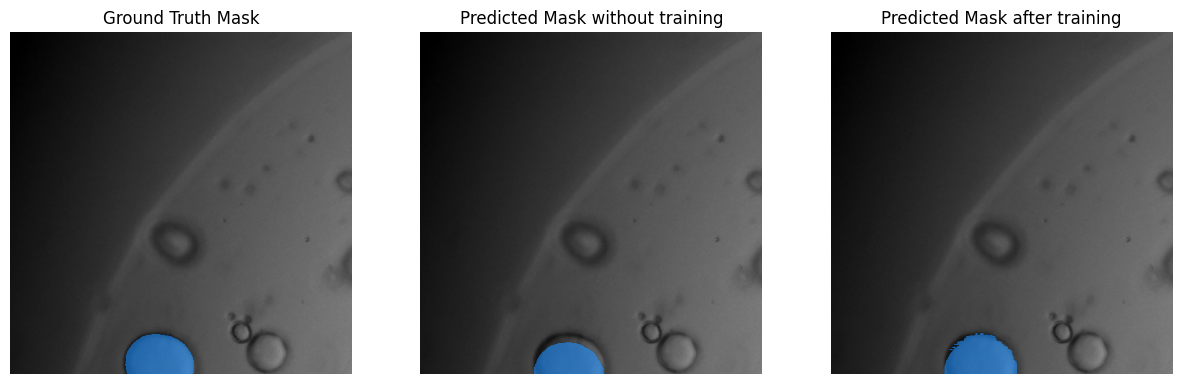

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Compute mask
outputs = model(pixel_values=batch["pixel_values"].to(device),
                input_boxes=batch["input_boxes"].to(device),
                multimask_output=False)
# Post-process mask
predicted_masks = outputs.pred_masks.to(device)
predicted_masks = F.interpolate(predicted_masks.squeeze(1), (1024, 1024), 
                                mode="bilinear", align_corners=False)
predicted_masks = predicted_masks[..., :992, :1024]
predicted_masks = F.interpolate(predicted_masks, (450, 450), 
                                mode="bilinear", align_corners=False)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Ground Truth Mask
ground_truth_masks = batch["ground_truth_mask"].float().squeeze().cpu()
axes[0].imshow(np.array(batch["original_image"]).squeeze())
show_mask(ground_truth_masks, axes[0])
axes[0].set_title("Ground Truth Mask")
axes[0].axis("off")

# Plot initial predicted mask
axes[1].imshow(np.array(batch["original_image"]).squeeze())
show_mask(first_mask_seg, axes[1])
axes[1].set_title("Predicted Mask without training")
axes[1].axis("off")

# Plot predicted mask after training
axes[2].imshow(np.array(batch["original_image"]).squeeze())
# apply sigmoid
mask_seg_prob = torch.sigmoid(predicted_masks)
# convert soft mask to hard mask
mask_seg_prob = mask_seg_prob.cpu().squeeze().detach().numpy()
mask_seg = (mask_seg_prob > 0.5).astype(np.uint8)
show_mask(mask_seg, axes[2])
axes[2].set_title("Predicted Mask after training")
axes[2].axis("off")

plt.show()